<a href="https://colab.research.google.com/github/laibamushtaq0/data-science-internship-2025/blob/main/task4_HousePricePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## TASK 4: Predicting House Prices

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Load from CSV
df = pd.read_csv("boston.csv")

# Separate features and target
X = df.drop(columns=['MEDV'])  # Assuming MEDV is the target
y = df['MEDV']

# Normalize features
X = (X - X.mean()) / X.std()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, random_state=42)


In [2]:
class LinearRegressionScratch:
    def __init__(self, lr=0.01, n_iter=1000):
        self.lr = lr
        self.n_iter = n_iter

    def fit(self, X, y):
        self.n_samples, self.n_features = X.shape
        self.weights = np.zeros(self.n_features)
        self.bias = 0

        for _ in range(self.n_iter):
            y_pred = np.dot(X, self.weights) + self.bias
            dw = -(2/self.n_samples) * np.dot(X.T, (y - y_pred))
            db = -(2/self.n_samples) * np.sum(y - y_pred)
            self.weights -= self.lr * dw
            self.bias -= self.lr * db

    def predict(self, X):
        return np.dot(X, self.weights) + self.bias


In [3]:
import random

class DecisionTreeRegressorScratch:
    def __init__(self, max_depth=5, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split

    def fit(self, X, y, depth=0):
        self.n_samples, self.n_features = X.shape
        self.value = np.mean(y)
        self.depth = depth

        if self.depth < self.max_depth and self.n_samples >= self.min_samples_split:
            self.best_feature, self.best_threshold = self.find_best_split(X, y)
            if self.best_feature is not None:
                left_idx = X[:, self.best_feature] <= self.best_threshold
                right_idx = X[:, self.best_feature] > self.best_threshold
                self.left = DecisionTreeRegressorScratch(self.max_depth, self.min_samples_split)
                self.right = DecisionTreeRegressorScratch(self.max_depth, self.min_samples_split)
                self.left.fit(X[left_idx], y[left_idx], depth+1)
                self.right.fit(X[right_idx], y[right_idx], depth+1)

    def find_best_split(self, X, y):
        best_mse = float("inf")
        best_feature, best_threshold = None, None
        for feature in range(X.shape[1]):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                left_idx = X[:, feature] <= threshold
                right_idx = X[:, feature] > threshold
                if len(y[left_idx]) == 0 or len(y[right_idx]) == 0:
                    continue
                mse = (len(y[left_idx]) * np.var(y[left_idx]) + len(y[right_idx]) * np.var(y[right_idx])) / len(y)
                if mse < best_mse:
                    best_mse = mse
                    best_feature = feature
                    best_threshold = threshold
        return best_feature, best_threshold

    def predict(self, X):
        if hasattr(self, 'best_feature'):
            if X[self.best_feature] <= self.best_threshold:
                return self.left.predict(X)
            else:
                return self.right.predict(X)
        else:
            return self.value


class RandomForestRegressorScratch:
    def __init__(self, n_estimators=10, max_depth=5, min_samples_split=2):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_estimators):
            idxs = np.random.choice(len(X), len(X), replace=True)
            tree = DecisionTreeRegressorScratch(max_depth=self.max_depth, min_samples_split=self.min_samples_split)
            tree.fit(X[idxs], y[idxs])
            self.trees.append(tree)

    def predict(self, X):
        tree_preds = np.array([tree.predict(x) for tree in self.trees for x in X])
        tree_preds = tree_preds.reshape(self.n_estimators, len(X))
        return np.mean(tree_preds, axis=0)


In [4]:
class XGBoostRegressorScratch:
    def __init__(self, n_estimators=10, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.trees = []

    def fit(self, X, y):
        self.pred = np.zeros(len(y))
        for _ in range(self.n_estimators):
            residuals = y - self.pred
            tree = DecisionTreeRegressorScratch(max_depth=self.max_depth)
            tree.fit(X, residuals)
            update = np.array([tree.predict(x) for x in X])
            self.pred += self.learning_rate * update
            self.trees.append(tree)

    def predict(self, X):
        pred = np.zeros(X.shape[0])
        for tree in self.trees:
            pred += self.learning_rate * np.array([tree.predict(x) for x in X])
        return pred


In [5]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    return rmse, r2


In [6]:
def feature_importance_rf(rf_model, feature_names):
    importance = {i: 0 for i in range(len(feature_names))}
    def count_splits(node):
        if hasattr(node, 'best_feature'):
            importance[node.best_feature] += 1
            count_splits(node.left)
            count_splits(node.right)

    for tree in rf_model.trees:
        count_splits(tree)

    plt.barh(feature_names, [importance[i] for i in range(len(feature_names))])
    plt.xlabel("Split Count")
    plt.title("Feature Importance (Random Forest)")
    plt.show()


Linear Regression: (np.float64(4.971153264273616), 0.6630152746535407)
Random Forest: (np.float64(3.362875143673047), 0.845788274590848)


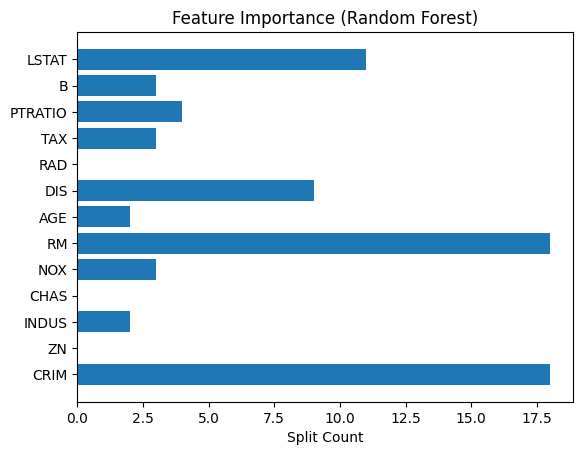

XGBoost: (np.float64(8.798107778344807), -0.05553944094421248)


In [7]:
if __name__ == "__main__":
    feature_names = X.columns.tolist()

    lr = LinearRegressionScratch()
    lr.fit(X_train, y_train)
    print("Linear Regression:", evaluate_model(lr, X_test, y_test))

    rf = RandomForestRegressorScratch(n_estimators=5, max_depth=4)
    rf.fit(X_train, y_train)
    print("Random Forest:", evaluate_model(rf, X_test, y_test))
    feature_importance_rf(rf, feature_names)

    xgb = XGBoostRegressorScratch(n_estimators=10, learning_rate=0.1, max_depth=3)
    xgb.fit(X_train, y_train)
    print("XGBoost:", evaluate_model(xgb, X_test, y_test))
